### Load data

In [81]:
import pandas as pd
import numpy as np

In [160]:
# load data from The U.S. Department of Transportation's
flights= pd.read_csv('./data/flights.csv', parse_dates=['DEPARTURE_TIME', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'])

/Users/pyt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [161]:
flights.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE     object
DEPARTURE_TIME          object
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL       object
ARRIVAL_TIME            object
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

In [84]:
airports=pd.read_csv('./data/airports.csv')

In [85]:
airports.size

2254

In [86]:
airlines=pd.read_csv('./data/airlines.csv')

In [162]:
print('Total flight rows are: '+str(flights['ORIGIN_AIRPORT'].size))

Total flight rows are: 5819079


### Save to pickle for easy loading in future

In [163]:
flights.to_pickle('./data/flights.pkl')

In [90]:
airports.to_pickle('./data/airports.pkl')

In [91]:
airlines.to_pickle('./data/airlines.pkl')

### Load pickle files

In [2]:
flights=pd.read_pickle('./data/flights.pkl')

In [3]:
airports=pd.read_pickle('./data/airports.pkl')

In [4]:
airlines=pd.read_pickle('./data/airlines.pkl')

## Merge airport and volume data

In [92]:
airport_vol=pd.read_csv('./data/airport_volume.csv')

In [93]:
airports=airports.merge(airport_vol, left_on='IATA_CODE', right_on='IATA_CODE', how='inner', left_index=True)

In [94]:
airports=airports.rename(columns={'PASS_DEPART': 'PASS_DEPART(K)'})

In [95]:
airports['PASS_DEPART(K)']=airports['PASS_DEPART(K)'].str.replace('k','')
airports['PASS_DEPART(K)']=airports['PASS_DEPART(K)'].str.replace(',','')
airports['FLIGHT_DEPART']=airports['FLIGHT_DEPART'].str.replace(',','')

In [96]:
airports['PASS_DEPART(K)']=pd.to_numeric(airports['PASS_DEPART(K)'])
airports['FLIGHT_DEPART']=pd.to_numeric(airports['FLIGHT_DEPART'])

In [97]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,Unnamed: 0,PASS_DEPART(K),FLIGHT_DEPART
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,0,318,6230
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,1,84,3041
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,2,2320,29424
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,3,27,1007
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,4,34,1479


### Explore and clean flights data

In [164]:
flights['DATE'] = flights['MONTH'].map(str) + '/' + flights['DAY'].map(str) + '/' + flights['YEAR'].map(str)

In [165]:
# convert to time for time columns
flights['DEPARTURE_DT']=pd.to_datetime(flights['DATE'].map(str)+' '+flights['DEPARTURE_TIME'].map(str), format='%m/%d/%Y %H%M', errors='coerce')
flights['ARRIVAL_DT']=pd.to_datetime(flights['DATE'].map(str)+' '+flights['ARRIVAL_TIME'], format='%m/%d/%Y %H%M', errors='coerce')


In [166]:
from datetime import timedelta
#validate scheduled arrival DT is correct by checking date for scheduled departure + scheduled time
flights['ARRIVAL_DT2']=pd.to_datetime(flights['DEPARTURE_DT']) + pd.to_timedelta(flights['SCHEDULED_TIME'], unit='m')

In [167]:
flights=flights.sort_values(by=['TAIL_NUMBER', 'DEPARTURE_DT'])

In [168]:
# create new column to account for delays due to inbound plane
flights['INBOUND_DELAY']=flights.groupby('TAIL_NUMBER')['ARRIVAL_DELAY'].apply(lambda x: x.shift(1))

In [169]:
flights[['TAIL_NUMBER','DEPARTURE_DT', 'ARRIVAL_DT','ARRIVAL_DELAY','INBOUND_DELAY']].head()

,TAIL_NUMBER,DEPARTURE_DT,ARRIVAL_DT,ARRIVAL_DELAY,INBOUND_DELAY
3052236,7819A,2015-07-10 19:42:00,2015-07-10 00:48:00,3.0,NaN
3055380,7819A,2015-07-11 05:56:00,2015-07-11 09:03:00,-7.0,3.0
3059072,7819A,2015-07-11 09:44:00,2015-07-11 11:00:00,-25.0,-7.0
3061230,7819A,2015-07-11 11:56:00,2015-07-11 14:20:00,-15.0,-25.0
3064226,7819A,2015-07-11 15:21:00,2015-07-11 18:39:00,NaN,-15.0


In [171]:
# drop flights that did not have departure delay data (e.g. cancelled)
flights.dropna(subset=['DEPARTURE_DELAY'], inplace=True)

In [172]:
print('Total flights with departure data are: '+str(flights['ORIGIN_AIRPORT'].size))

Total flights with departure data are: 5732926


In [173]:
# rows are dropped as a result of the merge, where airport codes cannot be matched
flights2=flights.merge(airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')

In [174]:
print('Total flights with departure data are after cleaning: '+str(flights2['ORIGIN_AIRPORT'].size))

Total flights with departure data are after cleaning: 5249100


### Get subset of data to train

In [176]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DATE', 'DEPARTURE_DT',
       'ARRIVAL_DT', 'ARRIVAL_DT2', 'INBOUND_DELAY'],
      dtype='object')

In [183]:
flights2=flights2[['DEPARTURE_DELAY', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE','INBOUND_DELAY', 'FLIGHT_DEPART' ]]

In [205]:
flights2.dtypes

DEPARTURE_DELAY    float64
MONTH                int64
DAY                  int64
DAY_OF_WEEK          int64
AIRLINE             object
INBOUND_DELAY      float64
FLIGHT_DEPART        int64
dtype: object

In [204]:
flights2.dropna(subset=['INBOUND_DELAY'], inplace=True)

/Users/pyt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [185]:
flights2.to_pickle('./data/flights2.pkl')

In [ ]:
flights2=pd.read_pickle('./data/flights2.pkl')

In [206]:
flights3=flights2.copy()
flights3=pd.get_dummies(flights2)

In [207]:
flights3.dtypes

DEPARTURE_DELAY    float64
MONTH                int64
DAY                  int64
DAY_OF_WEEK          int64
INBOUND_DELAY      float64
FLIGHT_DEPART        int64
AIRLINE_AA           uint8
AIRLINE_AS           uint8
AIRLINE_B6           uint8
AIRLINE_DL           uint8
AIRLINE_EV           uint8
AIRLINE_F9           uint8
AIRLINE_HA           uint8
AIRLINE_MQ           uint8
AIRLINE_NK           uint8
AIRLINE_OO           uint8
AIRLINE_UA           uint8
AIRLINE_US           uint8
AIRLINE_VX           uint8
AIRLINE_WN           uint8
dtype: object

### Perform train/val split

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
%matplotlib inline

In [208]:
X=flights3.iloc[:,1:]
y=flights3.iloc[:,0]
print(X.shape)
print(y.shape)

(5225963, 19)
(5225963,)


In [210]:
# perform train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Try to model and fit

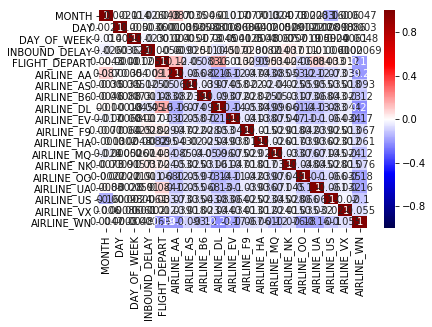

In [211]:
sns.heatmap(X_train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [212]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr.score(X_train,y_train)

0.14222742447408843

In [213]:
# score fit model on validation data
val_score = lr.score(X_val, y_val)

# report results
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr.coef_):
    print(feature, ':', f'{coef:.2f}')


Validation R^2 score was: 0.14257320802046836
Feature coefficient results: 

MONTH : -0.06
DAY : 0.00
DAY_OF_WEEK : -0.12
INBOUND_DELAY : 0.34
FLIGHT_DEPART : 0.00
AIRLINE_AA : 0.20
AIRLINE_AS : -4.81
AIRLINE_B6 : 2.39
AIRLINE_DL : -0.26
AIRLINE_EV : -0.80
AIRLINE_F9 : 1.78
AIRLINE_HA : -6.54
AIRLINE_MQ : 0.47
AIRLINE_NK : 3.86
AIRLINE_OO : -1.17
AIRLINE_UA : 5.25
AIRLINE_US : -2.79
AIRLINE_VX : 0.12
AIRLINE_WN : 2.31


In [214]:
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

model = sm.OLS(y_train, X_train)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        DEPARTURE_DELAY   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                 3.851e+04
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        17:05:12   Log-Likelihood:            -2.0706e+07
No. Observations:             4180770   AIC:                         4.141e+07
Df Residuals:                 4180751   BIC:                         4.141e+07
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MONTH            -0.0642      0.005    -12.726      0.000      -0.074      -0.054
DAY               0.0003      0.002      0.178      0.859      -0.003       0.004
DAY_OF_WEEK      -0.1170      0.008    -13.897      0.000      -0.133      -0.100
INBOUND_DELAY     0.3427      0.000    810.140      0.000       0.342       0.344
FLIGHT_DEPART  9.736e-06   1.51e-07     64.362      0.000    9.44e-06       1e-05
AIRLINE_AA        6.8068      0.080     85.020      0.000       6.650       6.964
AIRLINE_AS        1.7928      0.113     15.900      0.000       1.572       2.014
AIRLINE_B6        8.9907      0.097     92.414      0.000       8.800       9.181
AIRLINE_DL        6.3391      0.076     83.755      0.000       6.191       6.487
AIRLINE_EV        5.7999      0.079     72.969      0.000       5.644       5.956
AIRLINE_F9        8.3847      0.148     56.821      0.000       8.095       8.674
AIRLINE_HA        0.0615      0.155      0.396      0.692      -0.243       0.366
AIRLINE_MQ        7.0716      0.096     73.458      0.000       6.883       7.260
AIRLINE_NK       10.4626      0.133     78.386      0.000      10.201      10.724
AIRLINE_OO        5.4299      0.079     69.122      0.000       5.276       5.584
AIRLINE_UA       11.8547      0.083    142.052      0.000      11.691      12.018
AIRLINE_US        3.8094      0.103     37.036      0.000       3.608       4.011
AIRLINE_VX        6.7209      0.173     38.844      0.000       6.382       7.060
AIRLINE_WN        8.9133      0.068    131.835      0.000       8.781       9.046
==============================================================================
Omnibus:                  5829253.277   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4377000318.215
Skew:                           7.827   Prob(JB):                         0.00
Kurtosis:                     160.739   Cond. No.                     2.77e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

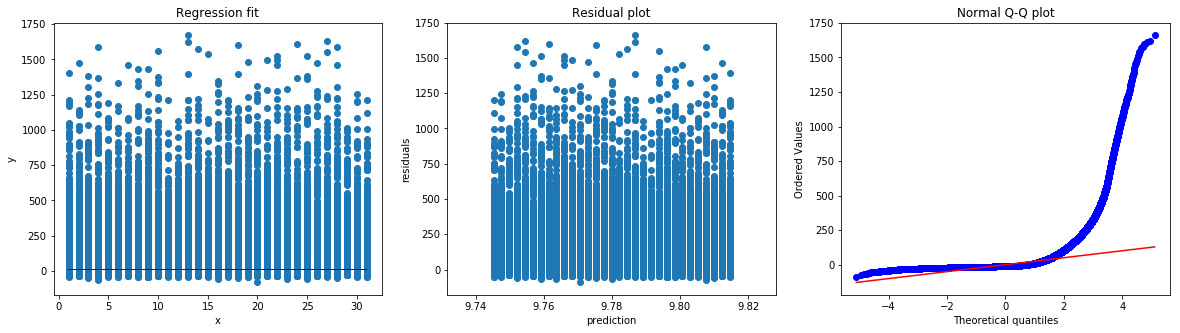

In [75]:
diagnostic_plot(X_train['DAY'].values.reshape(4199280, 1), y_train) 

In [65]:
X_train.shape

(4199280, 19)

In [58]:
y_train.shape

(4199280,)